# Survival Analysis of Ovarian Cancer

Through modern statistical methods, we can determine survival risk based on a variety of factors.  In this tutorial, we will walk through a small example of something you could do with our data to understand what factors relate with survival in various different types of cancer.  In this use case, we will be looking at Ovarian Cancer

## Step 1: Import Data and Dependencies

In [28]:
import pandas as pd
import cptac
import numpy as np
import seaborn as sns
import deva
import scipy
import matplotlib.pyplot as plt
import lifelines
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
from lifelines.statistics import proportional_hazard_test
%matplotlib inline

In [29]:
ov = cptac.Ovarian()
clinical = ov.get_clinical()
proteomics = ov.get_proteomics()
follow_up = ov.get_followup()

## Step 2: Data Preparation
We will be focusing on the discovery cohort of tumors, for which we have follow-up data. We will first merge the clinical and follow-up tables together for analysis. Then we will choose a few attributes to focus on, and narrow our dataframe to those attributes. While you could study a wide variety of factors related to survival, such as country of origin or number of full pregnancies, we will be focusing on tumor stage and grade.

In [30]:
follow_up = follow_up.rename({'PPID': 'Patient_ID'}, axis='columns')
focus_group = pd.merge(clinical, follow_up, on = "Patient_ID")

In [31]:
cols = list(clinical.columns)
omics_genes = ['GBP2', 'GBP5', 'RAC2', 'PODXL']

df_test = ov.join_metadata_to_omics(metadata_df_name="clinical", 
                                    omics_df_name="proteomics", 
                                    metadata_cols=cols, 
                                    omics_genes=omics_genes)
df_test = ov.reduce_multiindex(df_test, levels_to_drop="Database_ID")

focus_group = pd.merge(df_test, follow_up, on = "Patient_ID")

cptac warning: proteomics data was not found for the following samples, so proteomics data columns were filled with NaN for these samples: 01OV002, 01OV008, 01OV010, 01OV013, 01OV019, 01OV024, 01OV033, 01OV045, 01OV046, 01OV049, 02OV001, 02OV035, 02OV040, 02OV042, 02OV045, 04OV041, 11OV009, 11OV010, 13OV004, 14OV029, 17OV003, 17OV004, 17OV005, 17OV006, 17OV007, 17OV012, 17OV016, 17OV019, 17OV022, 17OV026, 17OV031, 17OV034, 17OV035, 17OV037, 17OV038, 22OV001, 26OV010 (C:\Users\Daniel\AppData\Local\conda\conda\envs\Research\lib\site-packages\ipykernel_launcher.py, line 7)


In [32]:
for i in range(len(omics_genes)):
    omics_genes[i] += "_proteomics"

In [33]:
cols_to_focus_on = ["Tumor_Stage_Ovary_FIGO", 
                    "Days_Between_Collection_And_Last_Contact", 
                    "Vital_Status", "Days_Between_Collection_And_Death", 
                    "Days_Between_Collection_And_New_Tumor_Event"]

for gene in omics_genes:
    cols_to_focus_on.append(gene)

focus_group = focus_group[cols_to_focus_on]

## Step 2b: Prepare data for Kaplan Meier Plotting
First, we will combine the timeframe columns into one single timeframe column to avoid missing values.

In [34]:
cols = ['Days_Between_Collection_And_Last_Contact', 'Days_Between_Collection_And_Death']

focus_group = focus_group.assign(Days_Until_Last_Contact_Or_Death=focus_group[cols].sum(1)).drop(cols, 1)

Now we can get rid of the redundant data columns and focus just on tumor stage and our proteins of interest.

In [35]:
cols = ["Tumor_Stage_Ovary_FIGO",
        "Vital_Status", 
        "Days_Until_Last_Contact_Or_Death"]

for gene in omics_genes:
    cols.append(gene)

focus_group = focus_group[cols].dropna().copy()

We will then update the column to contain boolean values, where True denotes that the event occurred ('Deceased'), and False denotes that it did not ('Living'). This is necessary to fit the requirements of the *lifelines* package.

In [36]:
focus_group['Vital_Status'] = focus_group['Vital_Status'].replace('Living', False)
focus_group['Vital_Status'] = focus_group['Vital_Status'].replace('Deceased', True)

This shows how many negative vs. positive events occurred in our dataset.  In this case, we had 209 survival cases and 25 death cases.

In [37]:
focus_group['Vital_Status'].value_counts()

False    215
True      25
Name: Vital_Status, dtype: int64

Here, we do preliminary comparison of protein expression between living and deceased cases to see if there are any significant differences upfront.  However, survival analysis will make this more apparent, and provide more meaningful information into when these expression differences may be relevant.

In [38]:
focus_group = focus_group.dropna(axis=0, how='any')
deceased = focus_group[focus_group["Vital_Status"] == True]
living = focus_group[focus_group["Vital_Status"] == False]
#living
for gene in omics_genes:
    print(gene)
    print(scipy.stats.ttest_ind(deceased[gene], living[gene]), '\n')

GBP2_proteomics
Ttest_indResult(statistic=-2.319543490345945, pvalue=0.021212794850570784) 

GBP5_proteomics
Ttest_indResult(statistic=-1.561353126023445, pvalue=0.11976914722462077) 

RAC2_proteomics
Ttest_indResult(statistic=-1.9605532861570505, pvalue=0.05109767399201438) 

PODXL_proteomics
Ttest_indResult(statistic=0.297904928357834, pvalue=0.7660356173921506) 



# Step 3: Kaplan-Meier Plots
Kaplan Meier plots show us the probability of some event occuring over a given length of time, based on some attribute(s).  Oftentimes, they are used to plot the probability of death for clinical attributes, however they could also be used in a variety of other contexts.

Here, we show a general Kaplan Meier Plot of survival overall for our cohort, using the KaplanMeierFitter() from the lifelines package.

In [17]:
time = focus_group['Days_Until_Last_Contact_Or_Death']
status = focus_group['Vital_Status']

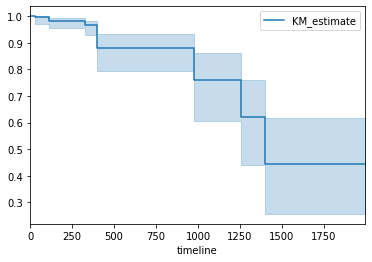

In [18]:
kmf = KaplanMeierFitter()
kmf.fit(time, event_observed = status)
kmf.plot()

# Step 4: Format data for Cox's Proportional Hazard test

With the CoxPHFitter from the *lifelines* package we can see covariate survival plots, as shown below.  However, in order to use this functionality, our data must be in a particular format:

1. It must include a numeric column indicating a time until event/last contact.
2. It must include a boolean column for the event of interest, where True corresponds with the event occuring, and False implies the event did not occur.
3. Other columns of attributes you are interested in.  In order for this to function properly, they need to be numerically categorized, meaning, if your data has 3 categories (i.e. FIGO stage I, II, and III), each of those categories requires a corresponding number (i.e. 1,2,3).  Below, we show how this can be done.

In [ ]:
#Assigning numeric labels to varying levels of protein expression per protein
for col in omics_genes:
    lower_25_filter = focus_group[col] <= focus_group[col].quantile(.25)
    upper_25_filter = focus_group[col] >= focus_group[col].quantile(.75)

    focus_group[col] = np.where(lower_25_filter, "Lower_25%", focus_group[col])
    focus_group[col] = np.where(upper_25_filter, "Upper_25%", focus_group[col])
    focus_group[col] = np.where(~lower_25_filter & ~upper_25_filter, 
                                "Middle_50%", focus_group[col])

proteomics_map = {"Lower_25%" : 1, "Middle_50%" : 2, "Upper_25%" : 3}
focus_group = focus_group.replace(proteomics_map)

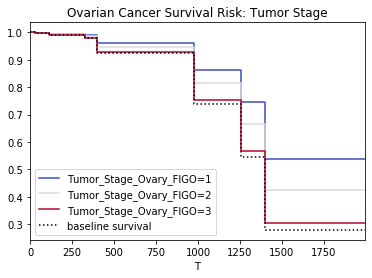

In [21]:
duration = "Days_Until_Last_Contact_Or_Death"
event = "Vital_Status"
cph = CoxPHFitter()
cph.fit(focus_group, duration_col = duration, event_col = event)
cph.plot_covariate_groups('Tumor_Stage_Ovary_FIGO', [1,2,3], cmap='coolwarm', 
                          title= "Ovarian Cancer Survival Risk: Tumor Stage")

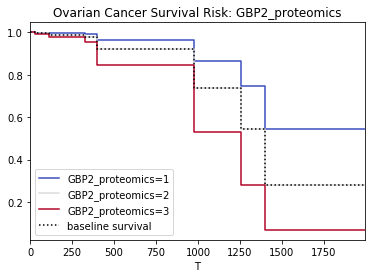

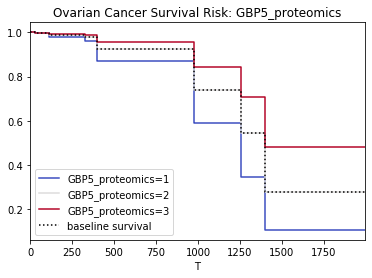

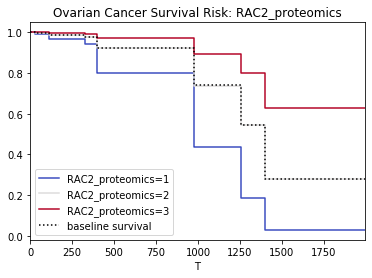

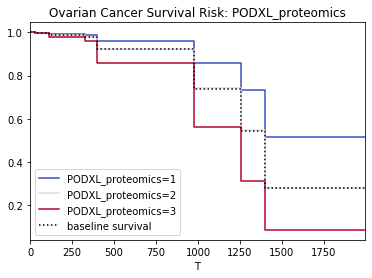

In [22]:
for gene in omics_genes:
    cph.plot_covariate_groups(gene, [1,2,3], cmap='coolwarm', 
                              title= "Ovarian Cancer Survival Risk: "+ gene)

CoxPHFitter() also provides us with a lot of other useful information about our data, including multivariate regression tests, proportional hazard tests, confidence intervals, among others.  These are a few of the features of *lifelines* that will be helpful in understanding and interpreting significance in your data.

In [43]:
#Regression Test
cph.print_summary(model="untransformed variables", decimals=3)

<lifelines.CoxPHFitter: fitted with 234 total observations, 209 right-censored observations>
      duration col = 'Days_Until_Last_Contact_Or_Death'
         event col = 'Vital_Status'
number of observations = 234.0
number of events observed = 25.0
partial log-likelihood = -91.909
  time fit was run = 2020-02-13 23:23:12 UTC
             model = untransformed variables


---
                         coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
Name                                                                                                                     
Tumor_Stage_Ovary_FIGO  0.327     1.386     0.444          -0.543           1.196               0.581               3.308
GBP2_proteomics         0.742     2.099     0.453          -0.145           1.628               0.865               5.096
GBP5_proteomics        -0.562     0.570     0.426          -1.397           0.274               0.247               1.315
RAC2_proteom

In [26]:
#Proportional hazard test
results = proportional_hazard_test(cph, df_genes, time_transform='rank')
results.print_summary(decimals=3, model="untransformed variables")

<lifelines.StatisticalResult>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
                        test_statistic       p  -log2(p)
GBP2_proteomics                  0.251   0.617     0.697
GBP5_proteomics                  0.618   0.432     1.212
PODXL_proteomics                13.328 <0.0005    11.901
RAC2_proteomics                  5.418   0.020     5.649
Tumor_Stage_Ovary_FIGO           6.845   0.009     6.814


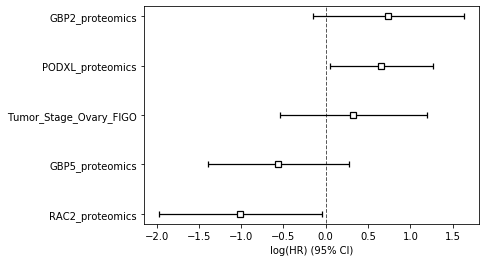

In [27]:
#Confidence Intervals Plotted
cph.plot()

In [44]:
#Confidence Intervals DataFrame
cph.confidence_intervals_

,95% lower-bound,95% upper-bound
Name,,
Tumor_Stage_Ovary_FIGO,-0.543052,1.196350
GBP2_proteomics,-0.145367,1.628415
GBP5_proteomics,-1.397288,0.274041
RAC2_proteomics,-1.968854,-0.048465
PODXL_proteomics,0.049494,1.265047
